In [4]:
import pandas as pd
df = pd.read_csv('/home/zhaohj/Documents/dataset/Kaggle/sartorius-cell-instance-segmentation/train.csv')
df

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def rle2mask(rle, img_w, img_h):
    
    array = np.fromiter(rle.split(), dtype = np.uint)
    array = array.reshape((-1,2)).T
    array[0] = array[0] - 1
    
    starts, lenghts = array
    
    mask_decompressed = np.concatenate([np.arange(s, s + l, dtype = np.uint) for s, l in zip(starts, lenghts)])

    msk_img = np.zeros(img_w * img_h, dtype = np.uint8)
    msk_img[mask_decompressed] = 1
    msk_img = msk_img.reshape((img_h, img_w))
    msk_img = np.asfortranarray(msk_img)
    
    return msk_img

118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 126594 18 127298 19 128002 20 128706 21 129410 22 130114 23 130818 24 131523 24 132227 25 132931 25 133635 24 134339 24 135043 23 135748 21 136452 19 137157 16 137864 11 138573 4


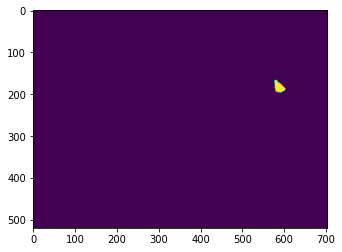

In [5]:
rle = df.loc[0, 'annotation']
print(rle)
plt.imshow(rle2mask(rle, 704, 520));


In [7]:
from tqdm.notebook import tqdm
from pycocotools import mask as maskUtils
def coco_structure(df):
    cat_ids = {name:id+1 for id, name in enumerate(df.cell_type.unique())}    
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in df.groupby('id').agg('first').iterrows()]
    annotations=[]
    for idx, row in tqdm(df.iterrows(), total = len(df)):
        mask = rle2mask(row['annotation'], row['width'], row['height'])
        c_rle = maskUtils.encode(mask)
        c_rle['counts'] = c_rle['counts'].decode('utf-8')
        area = maskUtils.area(c_rle).item()
        bbox = maskUtils.toBbox(c_rle).astype(int).tolist()
        annotation = {
            'segmentation': c_rle,
            'bbox': bbox,
            'area': area,
            'image_id':row['id'], 
            'category_id':cat_ids[row['cell_type']], 
            'iscrowd':0, 
            'id':idx
        }
        annotations.append(annotation)
    return {'categories':cats, 'images':images, 'annotations':annotations}

In [8]:
import json,itertools
root = coco_structure(df)

  0%|          | 0/73585 [00:00<?, ?it/s]

In [10]:
root['annotations'][0]

{'segmentation': {'size': [520, 704],
  'counts': 'WeT97Q`0<D6J2N1O01O101N1O1O0010O01O1O1N2O1N2O1N2O1N2O1N2N2M_Sc1'},
 'bbox': [576, 167, 27, 30],
 'area': 498,
 'image_id': '0030fd0e6378',
 'category_id': 1,
 'iscrowd': 0,
 'id': 0}

In [12]:
with open('/home/zhaohj/Documents/dataset/Kaggle/sartorius-cell-instance-segmentation/COCO/annotations_train.json', 'w', encoding='utf-8') as f:
    json.dump(root, f, ensure_ascii=True, indent=4)

In [14]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [16]:
dataDir=Path('/home/zhaohj/Documents/dataset/Kaggle/sartorius-cell-instance-segmentation')
annFile = Path('/home/zhaohj/Documents/dataset/Kaggle/sartorius-cell-instance-segmentation/COCO/annotations_train.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


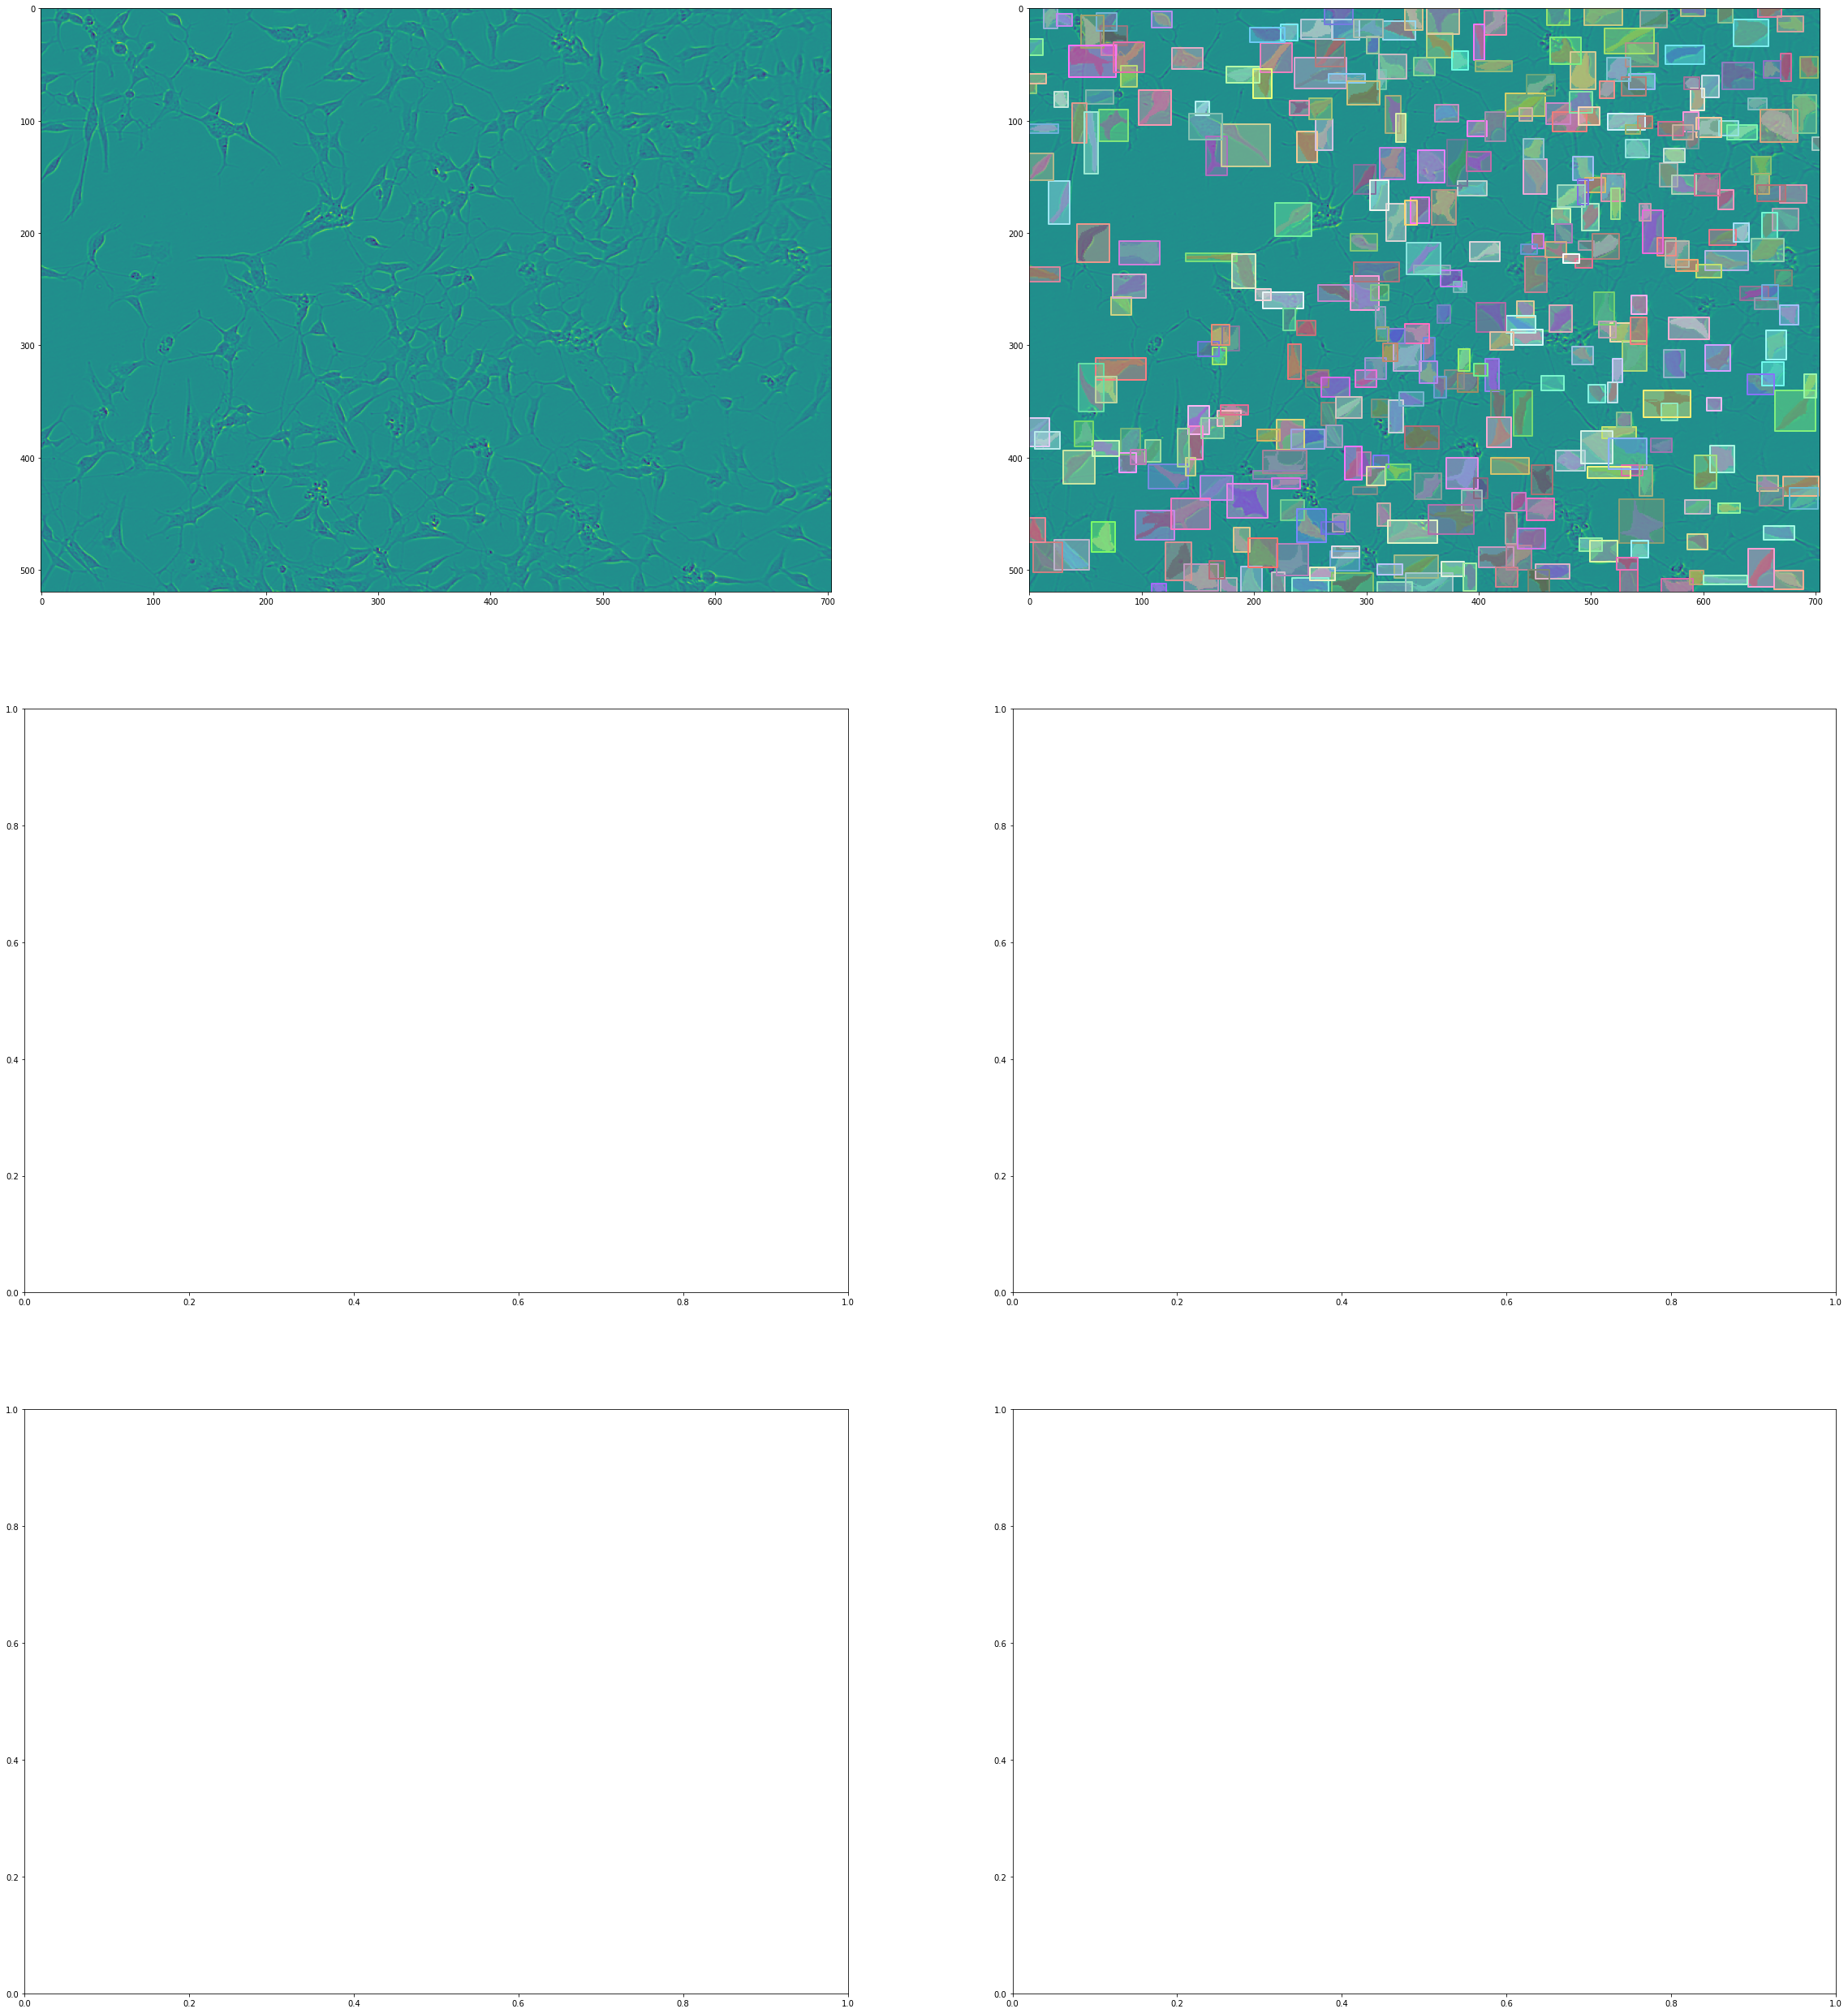

In [18]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = Image.open(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)
    break